# Switch between ONAN and ONAF

In this example we show how to use a conditional ONAF transformer that switches between ONAN and ONAF.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import (
    InputProfile,
    ThreeWindingInputProfile,
    UserThreeWindingTransformerSpecifications,
    UserTransformerSpecifications,
    WindingSpecifications,
)
from transformer_thermal_model.schemas.thermal_model import FanSwitchConfig, ONAFSwitch, ONANParameters
from transformer_thermal_model.transformer import PowerTransformer, ThreeWindingTransformer

We create an input profile similar to a regular simulation:

In [2]:
datetime_index = [pd.to_datetime("2025-01-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 1200, index=datetime_index)
# load_series = pd.Series(data=1800, index=datetime_index)
ambient_series = pd.Series(data=20, index=datetime_index)

# Create an input object with the profiles
my_profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

## Create the additional ONAFSwitch object

To create a transformer with configurable fans, we create a 'normal' ONAF transformer, but with some extra input parameters. There are two ways the ONAN-ONAF switch can be configured:

    - With an historical profile
    - With a threhshold temperature, at witch the fans turn on and off.

#### Case 1: With an historical fan profile

TO make a transformer with an ONAN/ONAF configuration we create the parameter class "ONAFSwitch", this has two parameters:
- onan_specs: ONANParameters. Her we pass along all ONAN paramters that are different when the fans are turned off. 
- fans_status: List[bool]. A list with booleans that indicate whether the fans are ON(ONAF) or off(ONAN).

In [3]:
my_transformer_specifications = UserTransformerSpecifications(
    load_loss=160000,  # Transformer load loss [W]
    nom_load_sec_side=3000,  # Transformer nominal current secondary side [A]
    no_load_loss=70000,  # Transformer no-load loss [W]
    amb_temp_surcharge=10,  # Ambient temperature surcharge [K]
    time_const_oil=150,  # Time constant oil [min]
    time_const_windings=7,  # Time constant windings [min]
    top_oil_temp_rise=50.5,  # Top-oil temperature rise [K]
    winding_oil_gradient=23,  # Winding oil gradient (worst case) [K]
    end_temp_reduction=0,  # Lowering of the end temperature with respect to the current specification [K]
    hot_spot_fac=1.2,  # Hot-spot factor [-]
    oil_const_k11=0.5,  # Oil constant k11 [-]
    winding_const_k21=2.0,  # Winding constant k21 [-]
    winding_const_k22=2.0,  # Winding constant k22 [-]
    oil_exp_x=0.8,  # Oil exponent x [-]
    winding_exp_y=1.3,  # Winding exponent x [-]
)

onan_specs = ONANParameters(
    top_oil_temp_rise=50.5,
    time_const_oil=150,
    time_const_windings=7,
    load_loss=160000,
    nom_load_sec_side=1600,  # Lower nominal current for ONAN mode
    winding_oil_gradient=23,
    hot_spot_fac=1.2,
)

# Create a fan schedule where the fans are off for the first half of the time and on for the second half
is_on = [False] * len(datetime_index)
for i in range(len(is_on) // 2, len(is_on)):
    is_on[i] = True

onaf_switch = ONAFSwitch(fans_status=is_on, onan_parameters=onan_specs)

We then define a PowerTransformer with the additional parameter `onaf_switch`:

In [4]:
my_transformer = PowerTransformer(
    user_specs=my_transformer_specifications, cooling_type=CoolerType.ONAF, onaf_switch=onaf_switch
)
my_model = Model(temperature_profile=my_profile_input, transformer=my_transformer)
results = my_model.run()

You can clearly see that both the hotspot and topoil temperature drop when the fans turn on:

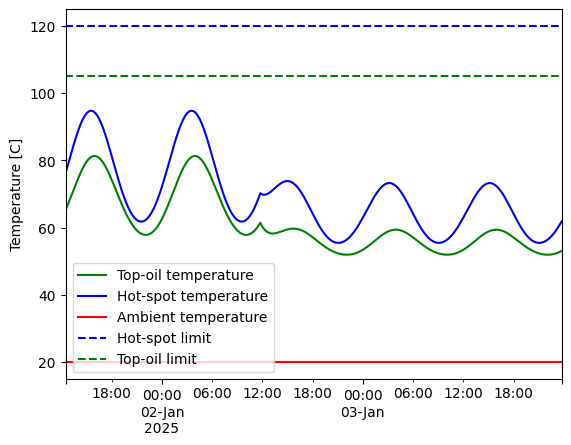

In [5]:
start_time = datetime_index[0] + pd.Timedelta(my_transformer.specs.time_const_oil * 5, "m")
fig = plt.figure()
ax = results.top_oil_temp_profile.loc[start_time::].plot(label="Top-oil temperature", color="green")
results.hot_spot_temp_profile.loc[start_time::].plot(label="Hot-spot temperature", color="blue")
ambient_series.loc[start_time::].plot(label="Ambient temperature", color="red")
ax.set_ylabel("Temperature [C]")
ax.hlines(120, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Hot-spot limit", color="blue")
ax.hlines(105, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Top-oil limit", color="green")
ax.legend(loc="lower left")
plt.show()

#### Case 2: With a threshold temperature

In [6]:
onaf_switch = ONAFSwitch(
    temperature_threshold=FanSwitchConfig(activation_temp=75, deactivation_temp=65),
    onan_parameters=onan_specs,
)
my_transformer = PowerTransformer(
    user_specs=my_transformer_specifications, cooling_type=CoolerType.ONAF, onaf_switch=onaf_switch
)
my_model = Model(temperature_profile=my_profile_input, transformer=my_transformer)
results = my_model.run()

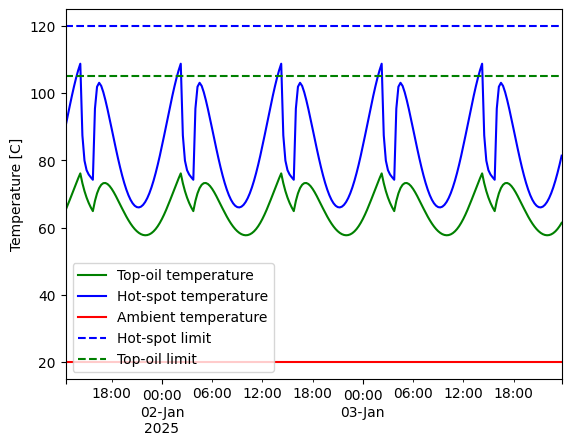

In [7]:
start_time = datetime_index[0] + pd.Timedelta(my_transformer.specs.time_const_oil * 5, "m")
fig = plt.figure()
ax = results.top_oil_temp_profile.loc[start_time::].plot(label="Top-oil temperature", color="green")
results.hot_spot_temp_profile.loc[start_time::].plot(label="Hot-spot temperature", color="blue")
ambient_series.loc[start_time::].plot(label="Ambient temperature", color="red")
ax.set_ylabel("Temperature [C]")
ax.hlines(120, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Hot-spot limit", color="blue")
ax.hlines(105, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Top-oil limit", color="green")
ax.legend(loc="lower left")
plt.show()

#### ONAN ONAF for a three winding transformer

In [8]:
# Define the time range for your simulation
datetime_index = [pd.to_datetime("2025-07-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series_high = pd.Series(
    data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index
)
load_series_middle = pd.Series(
    data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index
)
load_series_low = pd.Series(
    data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index
)

ambient_series = pd.Series(data=20, index=datetime_index)

# Create the input profile for the three-winding transformer
profile_input = ThreeWindingInputProfile.create(
    datetime_index=datetime_index,
    ambient_temperature_profile=ambient_series,
    load_profile_high_voltage_side=load_series_high,
    load_profile_middle_voltage_side=load_series_middle,
    load_profile_low_voltage_side=load_series_low,
)

In [9]:
# Define the transformer specifications for each winding
user_specs = UserThreeWindingTransformerSpecifications(
    no_load_loss=20,
    amb_temp_surcharge=10,
    lv_winding=WindingSpecifications(
        nom_load=1000, winding_oil_gradient=20, hot_spot_fac=1.2, time_const_winding=1, nom_power=1000
    ),
    mv_winding=WindingSpecifications(
        nom_load=1000, winding_oil_gradient=20, hot_spot_fac=1.2, time_const_winding=1, nom_power=1000
    ),
    hv_winding=WindingSpecifications(
        nom_load=2000, winding_oil_gradient=20, hot_spot_fac=1.2, time_const_winding=1, nom_power=2000
    ),
    load_loss_hv_lv=100,
    load_loss_hv_mv=100,
    load_loss_mv_lv=100,
)

In [ ]:
from transformer_thermal_model.schemas.thermal_model.onaf_switch import (
    ONANWindingParameters,
    ThreeWindingONAFSwitch,
    ThreeWindingONANParameters,
)

onan_parameters = ThreeWindingONANParameters(
    onan_lv_winding=ONANWindingParameters(
        time_const_winding=1, nom_load=800, winding_oil_gradient=20, hot_spot_fac=1.2
    ),
    onan_mv_winding=ONANWindingParameters(
        time_const_winding=1, nom_load=800, winding_oil_gradient=20, hot_spot_fac=1.2
    ),
    onan_hv_winding=ONANWindingParameters(
        time_const_winding=1, nom_load=1200, winding_oil_gradient=20, hot_spot_fac=1.2
    ),
    top_oil_temp_rise=60,
    time_const_oil=150,
    load_loss_mv_lv=100,
    load_loss_hv_lv=100,
    load_loss_hv_mv=100,
)

# split in three parts: off, on, off
point_1 = 20
point_2 = 20
is_on = [False] * point_1 + [True] * (len(profile_input.datetime_index) - point_1 - point_2) + [False] * point_2

onaf_switch = ThreeWindingONAFSwitch(fans_status=is_on, temperature_threshold=None, onan_parameters=onan_parameters)
transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAF, onaf_switch=onaf_switch)
model = Model(transformer=transformer, temperature_profile=profile_input)
results = model.run()

full_onaf_transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAF)
full_onaf_model = Model(transformer=full_onaf_transformer, temperature_profile=profile_input)
full_onaf_results = full_onaf_model.run()

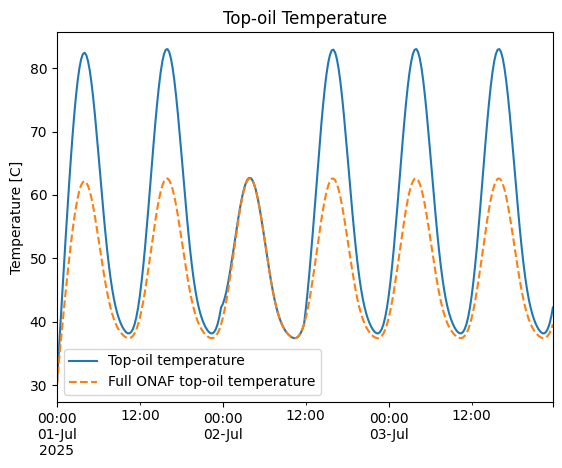

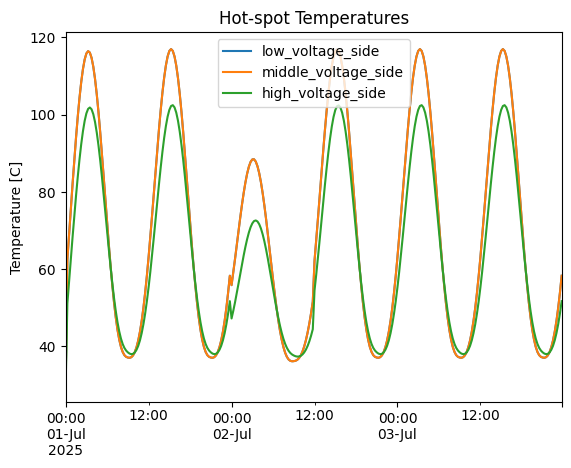

In [55]:
# Plot the top-oil temperature profile
fig1, ax1 = plt.subplots()
results.top_oil_temp_profile.plot(ax=ax1, label="Top-oil temperature")
full_onaf_results.top_oil_temp_profile.plot(ax=ax1, label="Full ONAF top-oil temperature", linestyle="dashed")
ax1.set_title("Top-oil Temperature")
ax1.set_ylabel("Temperature [C]")
ax1.legend()
plt.show()

# Plot the hot-spot temperature profiles
fig2, ax2 = plt.subplots()
results.hot_spot_temp_profile.plot(ax=ax2)
ax2.set_title("Hot-spot Temperatures")
ax2.set_ylabel("Temperature [C]")
ax2.legend()
plt.show()

In [25]:
onaf_switch = ThreeWindingONAFSwitch(
    temperature_threshold=FanSwitchConfig(activation_temp=60, deactivation_temp=50), onan_parameters=onan_parameters
)
transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAF, onaf_switch=onaf_switch)
model = Model(transformer=transformer, temperature_profile=profile_input)
results = model.run()

full_onaf_transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAF)
full_onaf_model = Model(transformer=full_onaf_transformer, temperature_profile=profile_input)
full_onaf_results = full_onaf_model.run()

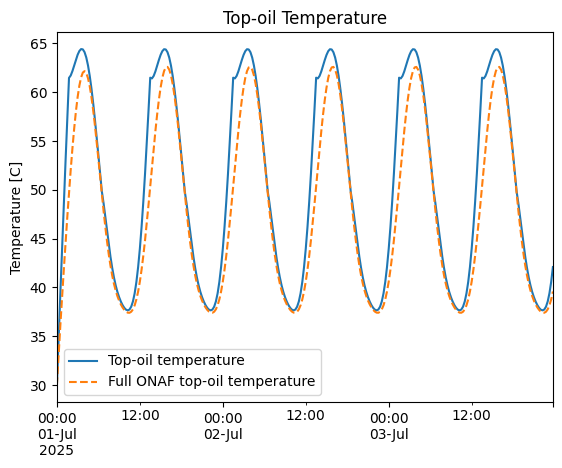

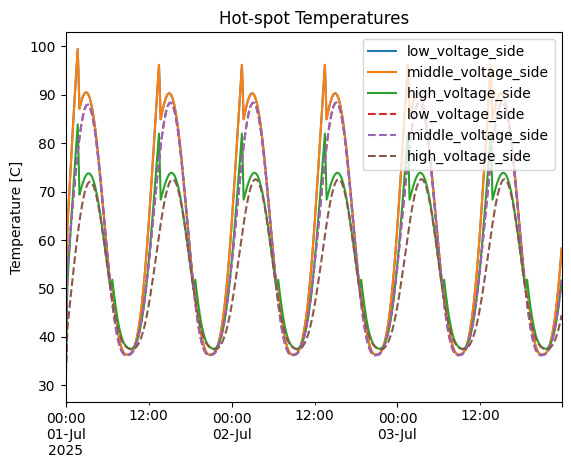

In [27]:
# Plot the top-oil temperature profile
fig1, ax1 = plt.subplots()
results.top_oil_temp_profile.plot(ax=ax1, label="Top-oil temperature")
full_onaf_results.top_oil_temp_profile.plot(ax=ax1, label="Full ONAF top-oil temperature", linestyle="dashed")
ax1.set_title("Top-oil Temperature")
ax1.set_ylabel("Temperature [C]")
ax1.legend()
plt.show()

# Plot the hot-spot temperature profiles
fig2, ax2 = plt.subplots()
results.hot_spot_temp_profile.plot(ax=ax2)
full_onaf_results.hot_spot_temp_profile.plot(ax=ax2, linestyle="dashed", label="Full ONAF hot-spot temperature")
ax2.set_title("Hot-spot Temperatures")
ax2.set_ylabel("Temperature [C]")
ax2.legend()
plt.show()

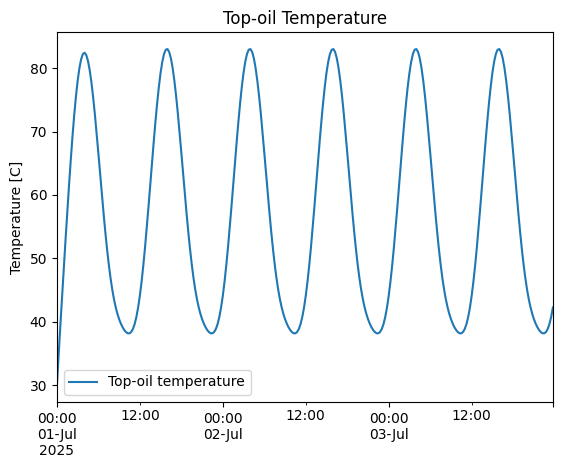

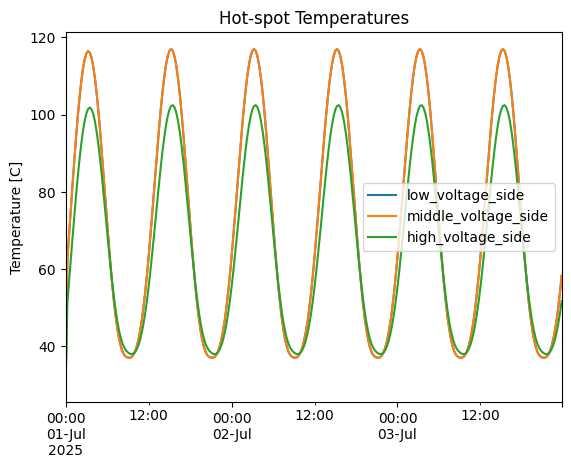

In [14]:
# Plot the top-oil temperature profile
fig1, ax1 = plt.subplots()
results.top_oil_temp_profile.plot(ax=ax1, label="Top-oil temperature")
ax1.set_title("Top-oil Temperature")
ax1.set_ylabel("Temperature [C]")
ax1.legend()
plt.show()

# Plot the hot-spot temperature profiles
fig2, ax2 = plt.subplots()
results.hot_spot_temp_profile.plot(ax=ax2)
ax2.set_title("Hot-spot Temperatures")
ax2.set_ylabel("Temperature [C]")
ax2.legend()
plt.show()

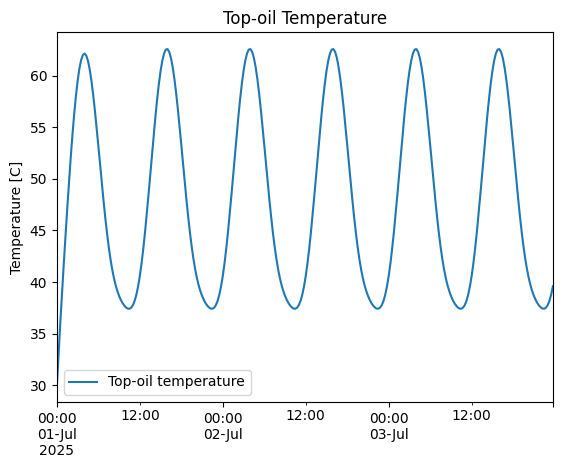

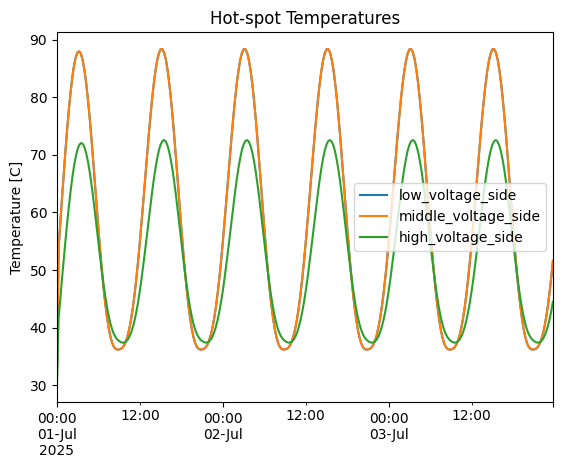

In [23]:
onaf_switch = ThreeWindingONAFSwitch(
    temperature_threshold=FanSwitchConfig(activation_temp=60, deactivation_temp=50), onan_parameters=onan_parameters
)
transformer = ThreeWindingTransformer(user_specs=user_specs, cooling_type=CoolerType.ONAF)
model = Model(transformer=transformer, temperature_profile=profile_input)
results = model.run()
# Plot the top-oil temperature profile
fig1, ax1 = plt.subplots()
results.top_oil_temp_profile.plot(ax=ax1, label="Top-oil temperature")
ax1.set_title("Top-oil Temperature")
ax1.set_ylabel("Temperature [C]")
ax1.legend()
plt.show()

# Plot the hot-spot temperature profiles
fig2, ax2 = plt.subplots()
results.hot_spot_temp_profile.plot(ax=ax2)
ax2.set_title("Hot-spot Temperatures")
ax2.set_ylabel("Temperature [C]")
ax2.legend()
plt.show()